In [ ]:
#Counting RBC
# - Created by: Alvin Tay
# - Created on: 12/09/19

In [ ]:
#Install opencv
#Install mahotas

In [2]:
#Libraries
from pylab import imshow, show
import numpy as np
import mahotas as mh
import cv2

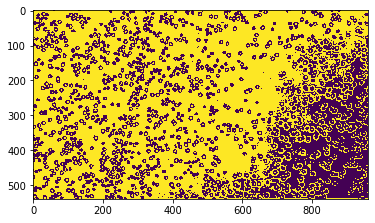

Found 1138 RBC.


In [3]:
#Reading original and count total no. of cells

#Method 1 - Gaussian Filter
#Ref: https://buildmedia.readthedocs.org/media/pdf/mahotas/stable/mahotas.pdf

#Read and display image
t_mh = mh.imread('A_20X_1.jpg')

#Filter image
t_mh = t_mh[:,:,0]            
t_mh = mh.gaussian_filter(t_mh, 0.7)  #Gaussian filter - blur edges and reduce noise

#Set threshold
t_mh = (t_mh > t_mh.mean())           #If pixel value > threshold, assign a value       
imshow(t_mh)
show()

#Label and Count
labeled, t_totalcells = mh.label(t_mh)
print('Found {} RBC.'.format(t_totalcells))

In [4]:
#Reading original and count total no of cells

#Method 2 - Finding and Counting Circles
#Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html

#Read image
t_cv2 = cv2.imread('A_20X_1.jpg', 0)                          #Reading image in greyscale mode
orig = cv2.imread('A_20X_1.jpg')                              #Reading image in colour mode

#Filter image
t_cv2 = cv2.medianBlur(t_cv2,5)                    #MedianBlur - reduce noises
img = cv2.cvtColor(t_cv2,cv2.COLOR_GRAY2BGR)

#Set circle parameters
circles = cv2.HoughCircles(t_cv2,cv2.HOUGH_GRADIENT,1,12,
                            param1=100,param2=3,minRadius=0,maxRadius=5)

#Draw circles
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)  # draw the outer circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)     # draw the center of the circle

#Show circled image
cv2.imshow('Detected circles',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
#cv2.imwrite('1_Total_A_20X_1.png', img)

#Count circles
cv2_totalcells = circles.shape[1]
print(cv2_totalcells) 

1294


In [ ]:
#Using method 2 due to lower percentage error and clearer visulisation of counting

In [5]:
#Labelling irregular shapes, ie. aggreagated RBC
#Ref: https://xbuba.com/questions/46036172

#Filter image
blur = cv2.medianBlur(orig,9)                   #GaussianBlur - blur image and reduce noise  
h, w = orig.shape[:2]

#Morphological gradient - outlining the object
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
cv2.imshow('Morphological gradient', gradient)
cv2.waitKey()
cv2.destroyAllWindows()

#Binarize gradient
lowerb = np.array([0, 0, 0])
upperb = np.array([40, 40, 40])
binary = cv2.inRange(gradient, lowerb, upperb)

#Flood fill (black) from the edges to remove edge cells
for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)

for col in range(w):
    if binary[0, col] == 255:                                   #Red, green, blue
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

#Cleaning up mask
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
cv2.imshow('Identified irregular shapes', foreground)
cv2.waitKey()
cv2.destroyAllWindows()

#Create background and unknown mask for labelling
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)

#Watershed markers
markers = cv2.connectedComponents(foreground)[1]
markers += 1                                                   #Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0                                      #Mark the region of unknown with zero
markers = cv2.watershed(orig, markers)

#Assign the watershed markers a red colour
hue_markers = np.uint8(1*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

#Label the original image with the red watershed markers
labeled_img = orig.copy()
labeled_img[markers>1] = marker_img[markers>1]                 #1 is background color
labeled_img = cv2.addWeighted(orig, 0.5, labeled_img, 0.5, 0)
cv2.imshow('Marked aggregated RBC.png', labeled_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [6]:
#Isolating irregular shapes, ie. aggregated RBC
#Ref: https://piratefsh.github.io/image-processing-101/

#Filter image
orig_hsv = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2HSV)

#Isolate irregular shapes using red watershed markers 
lower_red = np.array([0,100,100])
upper_red = np.array([20,255,255])
mask_inverse = cv2.inRange(orig_hsv, lower_red, upper_red)
mask = cv2.bitwise_not(mask_inverse)                           #Inverting the contrast of the image

#Convert single channel mask back into 3 channels
mask_rgb = cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB)

#Perform bitwise and on mask to obtain cut-out image that is not black
masked_orig = cv2.bitwise_and(orig, mask_rgb)

#Replace the cut-out parts with white
masked_replace_white = cv2.addWeighted(masked_orig, 1, \
                                       cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 1, 0)

#Display isolated irregular shapes, ie. aggregated RBC
isolate = cv2.cvtColor(masked_replace_white, cv2.COLOR_BGR2RGB)
cv2.imshow('Aggregated RBC', isolate)
cv2.waitKey()
cv2.destroyAllWindows()
#cv2.imwrite('2_Aggregated RBC.png', isolate)

In [7]:
#Finding and Counting Circles in aggregated cells
# - mulitple circles were found in aggregated cells
# - count the number of RBC involved in aggregation
#Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html

#Filter image
labeled_img = cv2.medianBlur(isolate,5)
img_g = cv2.cvtColor(labeled_img,cv2.COLOR_RGB2GRAY)

#Set circle parameters
circles = cv2.HoughCircles(img_g,cv2.HOUGH_GRADIENT,1,12,
                            param1=100,param2=3,minRadius=0,maxRadius=5)

#Draw circles
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img_g,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img_g,(i[0],i[1]),2,(0,0,255),3)

#Show circled image
cv2.imshow('Detected circles in aggregated cells',img_g)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Count circles
cv2_clump = circles.shape[1]                                  
print(cv2_clump) 

35


In [280]:
#Percentage of RBC involved in clumping
#Assuming all cells in the image are RBC

per_clump = (int(cv2_clump) / int(cv2_totalcells)) * 100
print('Percentage of RBC involved in clumping:', round(per_clump,2), '%')

Percentage of RBC involved in clumping: 38.57 %


In [ ]:
#----------------------------------------Optional-----------------------------------------------
#Identification of aggregated RBC, echinocytes, foreign particles
#Using method 2

In [ ]:
#Libaries
import cv2
import numpy as np
import mahotas as mh
import pylab as plb
import matplotlib.pyplot as plt
from pylab import imshow, show

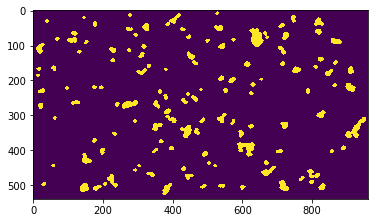

Found 126 RBC.


In [21]:
#Counting aggregated RBC as a whole
#Counting of colours
#Ref: https://buildmedia.readthedocs.org/media/pdf/mahotas/stable/mahotas.pdf

#Set threshold
aggr = mh.gaussian_filter(foreground, 1)                     #Gaussian filter - blur edges and reduce noise
aggr = (aggr > aggr.mean())                                  #If pixel value > threshold, assign a value
imshow(aggr)
show()

#Label and Count
labeled, n_aggr = mh.label(aggr)
print('Found {} RBC.'.format(n_aggr))

In [16]:
#Reading the dotted image
# - red dots = echinocytes
# - blue dots = foreign particles
#https://likegeeks.com/python-image-processing/#Color-Detection

#Read and show
img_cv = cv2.imread('X1.jpg')
c_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
cv2.imshow('Dotted image', c_img)
cv2.waitKey()
cv2.destroyAllWindows()

#Filter image
hsv_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

In [17]:
#Identification of colours - masking
# - identify red dots = echinocytes

lower_r = np.array([0,100,100]) 
upper_r = np.array([20,255,255])
masking_red = cv2.inRange(hsv_img, lower_r, upper_r)
cv2.imshow("Identified Echinocytes",masking_red)             #White dots = red
cv2.waitKey(0)
cv2.destroyAllWindows()

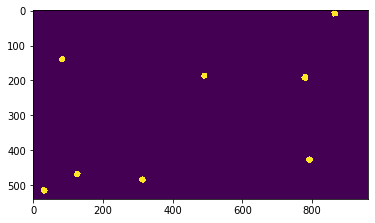

Found 8 echinocytes


In [18]:
#Counting of colours
# - count red  dots = echinocytes
#Ref: https://buildmedia.readthedocs.org/media/pdf/mahotas/stable/mahotas.pdf

#Set threshold
echin = mh.gaussian_filter(masking_red, 1)                   #Gaussian filter - blur edges and reduce noise
echin = (echin> echin.mean())                                #If pixel value > threshold, assign a value
imshow(echin)
show()

#Label and Count
labeled, label_echin = mh.label(echin)
n_echin = format(label_echin)
print('Found', n_echin, 'echinocytes')

In [23]:
#Identification of colours - masking
# - identify blue dots = foreign particles

lower_b = np.array([101,50,38])
upper_b = np.array([110,255,255])
masking_blue = cv2.inRange(hsv_img, lower_b, upper_b)
cv2.imshow("Identify Foreign Particles",masking_blue)        #white = blue
cv2.waitKey(0)
cv2.destroyAllWindows()

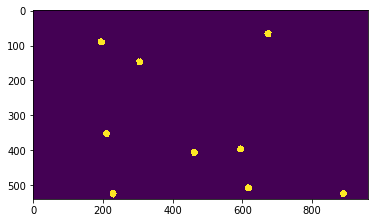

Found 9 foreign particles


In [24]:
#Counting of colours
# - count blue  dots = foreign particles
#Ref: https://buildmedia.readthedocs.org/media/pdf/mahotas/stable/mahotas.pdf

#Set threshold
fp = mh.gaussian_filter(masking_blue, 1)                     #Gaussian filter - blur edges and reduce noise
fp = (fp> fp.mean())                                         #If pixel value > threshold, assign a value
imshow(fp)
show()

#Label and Count
labeled, label_fp = mh.label(fp)
n_fp = format(label_fp)
print('Found', n_fp, 'foreign particles')

In [25]:
#Absolute value for RBC count
# = Total no of cells - no. of echinocytes - no. of foreign particles - no. of aggregated RBC

RBC = int(cv2_totalcells) - int(n_echin) - int(n_fp) - int(n_aggr)
print('Total number of RBC (excluding echinocytes and foreign particles): ', RBC)

Total number of RBC (excluding echinocytes and foreign particles):  896
